
This workshop aims at generating Land Surface Temperature (LST) and other relevant products (NDVI,Surface Emissivity, and  Fractional vegetation cover) 
for assessing urban climates (urban heat islands) from Landsat 8 imagery using open python geospatial tools.

In this workshop we will go through the workflow using the single channel approach by Jiménez-Muñoz et. al. 2009. 

We will end by assesing the tempertures and population distribution within the city of Tallinn. 

This will give planners and policy makers an idea where people are affected by heatwaves the highest within the city. 




Some resources:
    
How to download data: https://lta.cr.usgs.gov/sites/default/files/LS_C2_Help_122020.pd

Sobrino, J.A.; Jimenez-Muoz, J.C.; Soria, G.; Romaguera, M.; Guanter, L.; Moreno, J.;
Plaza, A.; Martinez, P., "Land Surface Emissivity Retrieval From Different VNIR and TIR Sensors," in Geoscience and Remote Sensing, IEEE Transactions on , vol.46, no.2, pp.316-
327, Feb. 2008 doi: 10.1109/TGRS.2007.904834
    
J. C. Jimenez-Munoz, J. Cristobal, J. A. Sobrino, G. Soria, M. Ninyerola and X. Pons, 
"Revision of the Single-Channel Algorithm for Land Surface Temperature Retrieval From Landsat Thermal-Infrared Data," 
in IEEE Transactions on Geoscience and Remote Sensing, vol. 47, no. 1, pp. 339-349, Jan. 2009, doi: 10.1109/TGRS.2008.2007125.
        


Data: Landsat 8 image on 18.07.2020

In [1]:
#import the needed packages

import os 
import glob

import numpy as np
import pandas as pd

import rasterio as rio
from rasterio.crs import CRS


import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from affine import Affine



import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import libpysal as lp
from splot.mapping import vba_choropleth, mapclassify_bin, vba_legend
import warnings
warnings.filterwarnings('ignore')

In [2]:
#define Image folder path and necessary bands



grids = gpd.read_file('../Data/grids/grids_1000_utm.geojson') # 500m grids over the area of interest

pop_data = pd.read_csv('../Data/grids/GRD1000_2017.csv') # population per 500 m grid of Estonia


images_path = '../Data/bands/' #path for folder containing all necessary bands and metadata info

mtl_path = os.path.join(images_path, '*MTL*') # metadata information



atm_params_path = os.path.join(images_path,'*atm*') # path for atmospheric parameters for calculating atm params

##################################################
#use glob to fetch the bands
b4_path = glob.glob(images_path+'*B4.tif')[0].replace('//','/')

b5_path = glob.glob(images_path+'*B5.tif')[0].replace('//','/')

b10_path = glob.glob(images_path+'*B10.tif')[0].replace('//','/')

meta_file = glob.glob(mtl_path)[0].replace('//','/')

atm_cor_params = glob.glob(atm_params_path)[0].replace('//','/')



We will create custom color maps for the parameters of interest. 

we wil use colors that are used in representing these parameters usually.


In [3]:
#create custom colour map
lst_cmap = mcl.LinearSegmentedColormap.from_list("", ["blue","lightskyblue","yellow","orange",'red'])

#create custom colour map
ndvi_cmap = mcl.LinearSegmentedColormap.from_list("", ["red","yellow","greenyellow","limegreen",'forestgreen','darkgreen'])


#create custom colour map
pop_cmap = mcl.LinearSegmentedColormap.from_list("", ["khaki","yellow","orange","darkgoldenrod","saddlebrown","maroon"])

In [4]:
grids.head(5)

,GRD_INSPIR,geometry
0,1kmN6583E0537,"MULTIPOLYGON (((707354.995 6588429.239, 707309..."
1,1kmN6583E0538,"MULTIPOLYGON (((708354.095 6588474.383, 708308..."
2,1kmN6590E0538,"MULTIPOLYGON (((708018.113 6595906.810, 708016..."
3,1kmN6587E0534,"MULTIPOLYGON (((704640.951 6593312.208, 705131..."
4,1kmN6589E0535,"MULTIPOLYGON (((705085.894 6594333.436, 705043..."


In [5]:
pop_data.head(5)

,GRD_INSPIR,TOTAL
0,1kmN6377E0650,0
1,1kmN6377E0651,0
2,1kmN6377E0652,0
3,1kmN6377E0653,0
4,1kmN6377E0655,0


In [6]:
#open and read (as arrays) the bands with rasterio

b4 = rio.open(b4_path).read(1)
b5 = rio.open(b5_path).read(1)
b10 = rio.open(b10_path).read(1)

transfromation = rio.open(b4_path).transform #to be used in final products


**calculate NDVI**

NDVI is the Normalized Difference Vegetation Index. It is arguably the most used index for vegetation assessment. 

Since the late 1960s researchers have used red and near-infrared light to estimate vegetation abundance using the NDVI.

The index is also used for urban climate studies.

The formula is given by:



$NDVI = \frac{\rho_{NIR} − \rho_{Red}}{\rho_{NIR} + \rho_{Red}}$

where $ \rho_{NIR} $ is the near-infrared band and $ \rho_{Red} $ is the red band.

the red band for landsat 8 is band 4 and the near-infrared is band 5


In [7]:
np.seterr(divide='ignore', invalid='ignore') #allow for the division by zero

ndvi = (b5.astype(float)-b4.astype(float))/(b5+b4) # calculate NDVI

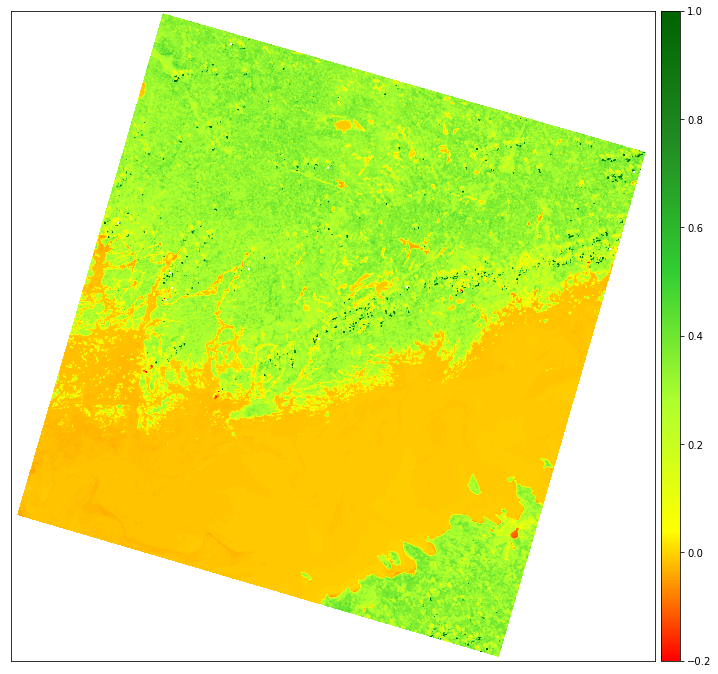

In [8]:
#visualize NDVI output

#plot ndvi
ep.plot_bands(ndvi, cmap=ndvi_cmap, cols=1, vmin=-0.2, vmax=1,scale=False)

In [9]:
!jt -t oceans16 -tf merriserif -tfs 14 -nf ptsans -nfs 14

'jt' is not recognized as an internal or external command,
operable program or batch file.




**Calculate Fractional Vegetation Cover (FVC)**

FVC is essential for calculating the land surface emmisivity. It can be estimated from the NDVI according to the following formula
 
$ FVC =  \frac{NDVI −  NDVI_{soil}  }  {NDVI_{veg} +  NDVI_{soil}}$ 

where $𝑁𝐷𝑉𝐼_{𝑠𝑜𝑖𝑙}$ is given as 0.2 and  $𝑁𝐷𝑉𝐼_{𝑣𝑒𝑔}$ is given as 0.5 (Sobrino et al. 2004; Yu et al. 2014)



In [10]:
#vegprop_2 = np.where(ndvi_2==-9999.0, -9999, (ndvi_2-0.2)/(0.5-0.2))

fvc = (ndvi-0.2)/(0.5-0.2)

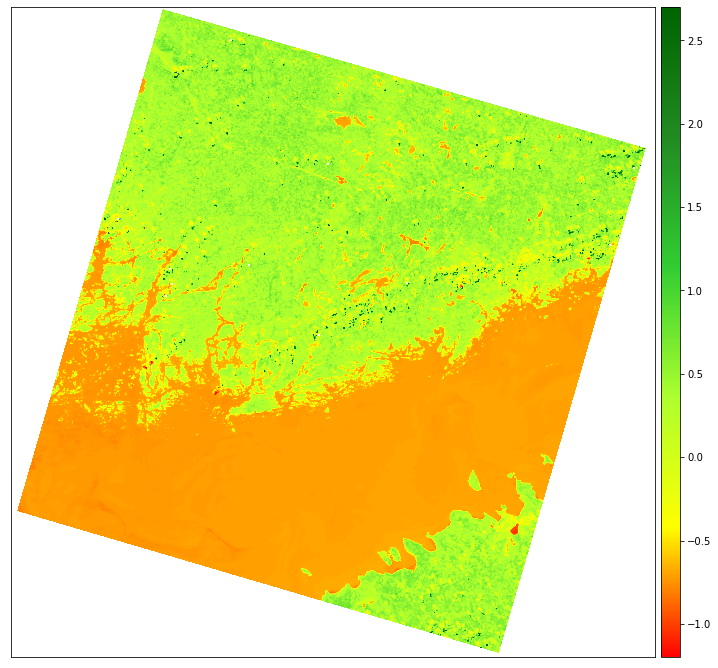

In [11]:
ep.plot_bands(fvc, cmap=ndvi_cmap, cols=1, vmin=-1.2, vmax=2.7,scale=False)

To estimate land surface emissivity (LSE) of mixed pixels using the equation from (Sobrino et al. 2004):
    
    
$$ \varepsilon =  \varepsilon_s(1−FVC)+ \varepsilon_v ∗FVC  $$

where εs and εv are emissivity values for soil and vegetation, respectively.


The emissivity values for soil and vegetation estimated at 0.97 and 0.99 respectively.


We will go through the image and calculate the emissivity for each pixel using the NDVI threshold method.

For

$NDVI ≤ 0.2$ : $LSE = 0.97$ - bare soils (low vegetaton)



$NDVI ≥ 0.5$ : $LSE = 0.99$ - mostly (healthy) vegetation


$0.2 < NDVI < 0.5$ : $LSE = 0.971*(1-fvc)+0.987*fvc$

In [12]:

emi = []

for row in range(len(ndvi)):                         #each row in the ndvi array
    
    emrow=[]                                              #emissivity of the row
    
    for i in range(len(ndvi[row])):                  #for each pixel in the row
        
        if ndvi[row][i] ==np.nan:
            emrow.append(np.nan)
            
        elif ndvi[row][i]<= 0.2:                    
            emrow.append(0.97)
            
        elif ndvi[row][i]>= 0.5:
            emrow.append(0.99)
            
        else:
            emrow.append(0.971*(1-fvc[row][i])+(0.987*fvc[row][i]))
    emi.append(emrow)
    
    
emiss = np.asarray(emi) #convert the emi to np array    

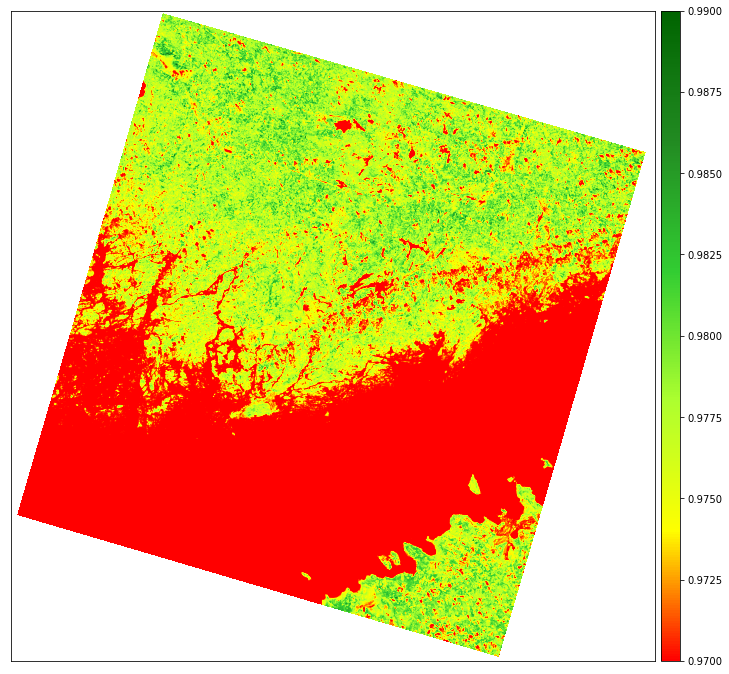

In [13]:
ep.plot_bands(emiss, cmap=ndvi_cmap, cols=1,scale=False)

bt represents the at-sensor brightness temperature which is calculated using :

    
$bt = \frac{K_2}{In  (\frac{K_1}{toa}+1)} $
    




$ \gamma = \frac {bt^2}  {K_2  *  toa}  $

$ \delta =  bt − \frac {bt^2}{K_2}  $

where $K_1$ and $K_2$ are thermal band constants provided in the metadata of the image.

For Landsat 8 $K_1$ = 774.8853 and $K_2$ = 1321.0789

In [14]:
#calculate at sensor radiance


toa = (b10.astype(float)*0.0003342)+0.1 #change mult constant if not L8


In [15]:
#calculate at sensor brightness temperature and convert to degree cel

bt = (1321.0789 / np.log((774.8853 / toa) + 1)) - 273.15


#calculate delta and gamma -- parameters based on Plank's functions



gamma = (bt*bt)/(1321.0789*toa) 

delta = bt - ((bt*bt)/1321.0789) 






We calculate atmospheric functions 𝜑1, 𝜑2, and 𝜑3 

from MODTRAN upwelling and downwelling estimations using the relationships in (Sobrino and Jiménez-Muñoz, 2010)
 
 
 
$ 𝜑_1= \frac{1}{𝜏} \\
   𝜑_2= −𝐿^↓ − \frac{𝐿^↑}{𝜏}\\
   𝜑_3= 𝐿^↓\\
$


where $τ$ is the atmospheric transmissivity, $L^↑$ is the upwelling atmospheric radiance, and $L^↓$ is the downwelling atmospheric radiance. These parameters can be obtained from the online calculator at https://atmcorr.gsfc.nasa.gov/ by providing date and time of image acquisition found in the metadata

In [16]:
#calcultate atm functions 


atm_params = list()        
with open (atm_cor_params, "r") as file:
    for line in file:
        atm_params.append(line.strip()) 
atm_params

transmission = float(atm_params[0][atm_params[0].find(':')+1:].strip())

upwelling_radiance= float(atm_params[1][atm_params[1].find(':')+4:atm_params[1].find('W')-1].
                          strip())

downwelling_radiance= float(atm_params[2][atm_params[2].find(':')+2:atm_params[2].find('W')-1].
                            strip())



w1 = 1/transmission

w2 =(-1*downwelling_radiance) - (upwelling_radiance/transmission)

w3 = downwelling_radiance





print (transmission,upwelling_radiance,downwelling_radiance)

0.65 2.82 4.41


Up until now we have generated all the required parameters to calculate the Land Surface Temperature.

The LST formular is given by :
    

    
$ lst = 𝛾 [\frac{1}{𝜀} (𝜑_1toa + 𝜑_2) + 𝜑_3] + 𝛿\\ $

In [18]:
lst = gamma*((((1/emiss)*((w1*toa)+w2)) + w3))+delta

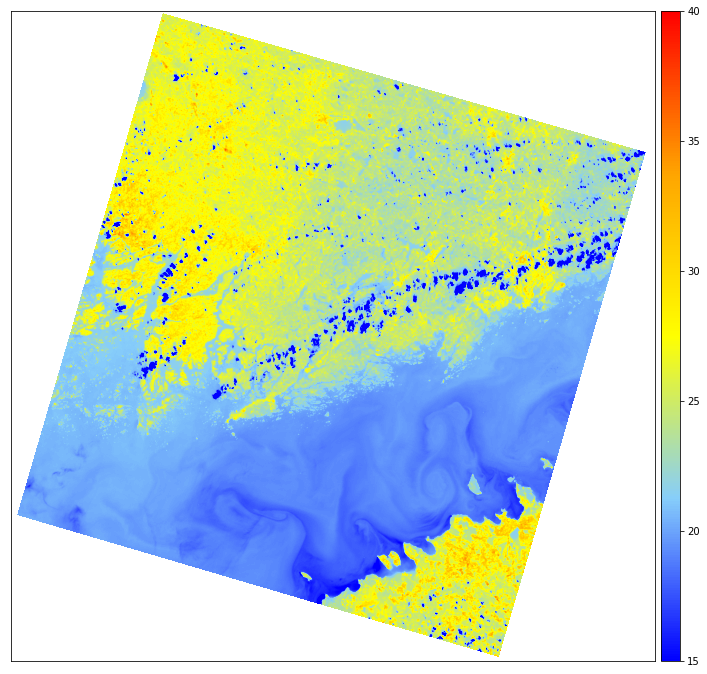

<function matplotlib.pyplot.show(*args, **kw)>

In [19]:
ep.plot_bands(lst, cmap=lst_cmap ,
              scale=False,
            vmin=15, vmax=40)
plt.show

Now we will extract the data for our area of interest using the 1km population grids. 

we will extract the NDVI and the LST for each grid using zonal statistics.

In [20]:
grids['ndvi'] = gpd.GeoDataFrame.from_features(
                                                zonal_stats(grids,                   #define polygon feature (grids)
                                                        ndvi,                        #input raster
                                                        stats='mean',                #statistic of interest
                                                        geojson_out=True,            #output as geojson
                                                        affine = transfromation)     #transformation
                                            )['mean'].round(2)                       #round ectracted values to 2 dp





grids['lst'] = gpd.GeoDataFrame.from_features(
                                                zonal_stats(grids, 
                                                        lst,
                                                        stats='mean',
                                                        geojson_out=True,
                                                        affine = transfromation)
                                            )['mean'].round(2)   
    

grids = grids.to_crs('EPSG:3301') #reproject from utm to Estonian projected CRS

In [21]:
#Quick look at our grid data

grids.head(10)

,GRD_INSPIR,geometry,ndvi,lst
0,1kmN6583E0537,"MULTIPOLYGON (((537000.000 6583000.000, 537000...",0.26,27.21
1,1kmN6583E0538,"MULTIPOLYGON (((538000.000 6583000.000, 538000...",0.25,27.46
2,1kmN6590E0538,"MULTIPOLYGON (((538000.000 6590439.176, 538000...",0.21,27.86
3,1kmN6587E0534,"MULTIPOLYGON (((534509.437 6588000.000, 535000...",0.10,25.24
4,1kmN6589E0535,"MULTIPOLYGON (((535000.000 6589000.000, 535000...",0.28,23.92
5,1kmN6581E0534,"MULTIPOLYGON (((535000.000 6581214.843, 535000...",0.33,24.67
6,1kmN6584E0545,"MULTIPOLYGON (((545000.000 6584000.000, 545000...",0.28,25.56
7,1kmN6580E0542,"MULTIPOLYGON (((542000.000 6580312.123, 542000...",0.07,24.15
8,1kmN6581E0542,"MULTIPOLYGON (((542000.000 6581000.000, 542000...",0.20,24.87
9,1kmN6582E0542,"MULTIPOLYGON (((542000.000 6582000.000, 542000...",0.26,26.13


Now we will joind the grid data to the population data by the ID field 'GRD_INSPIR'.

we will get the population for each grid, claculate the area of each grid(some grids are not full) and calculate the population densities.

In [22]:
grids['pop'] = grids.merge(pop_data,on='GRD_INSPIR')['TOTAL'] #merge and subset the Total column



grids['area'] = grids.area.round(2) #calulate the area of each grid





grids['pop_dens'] = (grids['pop'] /grids['area']).round(2)

In [23]:
grids.head(5)



,GRD_INSPIR,geometry,ndvi,lst,pop,area,pop_dens
0,1kmN6583E0537,"MULTIPOLYGON (((537000.000 6583000.000, 537000...",0.26,27.21,1798,1000000.00,0.0
1,1kmN6583E0538,"MULTIPOLYGON (((538000.000 6583000.000, 538000...",0.25,27.46,1743,1000000.00,0.0
2,1kmN6590E0538,"MULTIPOLYGON (((538000.000 6590439.176, 538000...",0.21,27.86,2963,619128.60,0.0
3,1kmN6587E0534,"MULTIPOLYGON (((534509.437 6588000.000, 535000...",0.10,25.24,205,507611.91,0.0
4,1kmN6589E0535,"MULTIPOLYGON (((535000.000 6589000.000, 535000...",0.28,23.92,362,555434.50,0.0


With all our desired information in one geodataframe, we can now visualize each parameter in the study area.

Let's start with plotting the LST and population side by side. 

Text(0.5, 1.0, 'Population - 1Km')

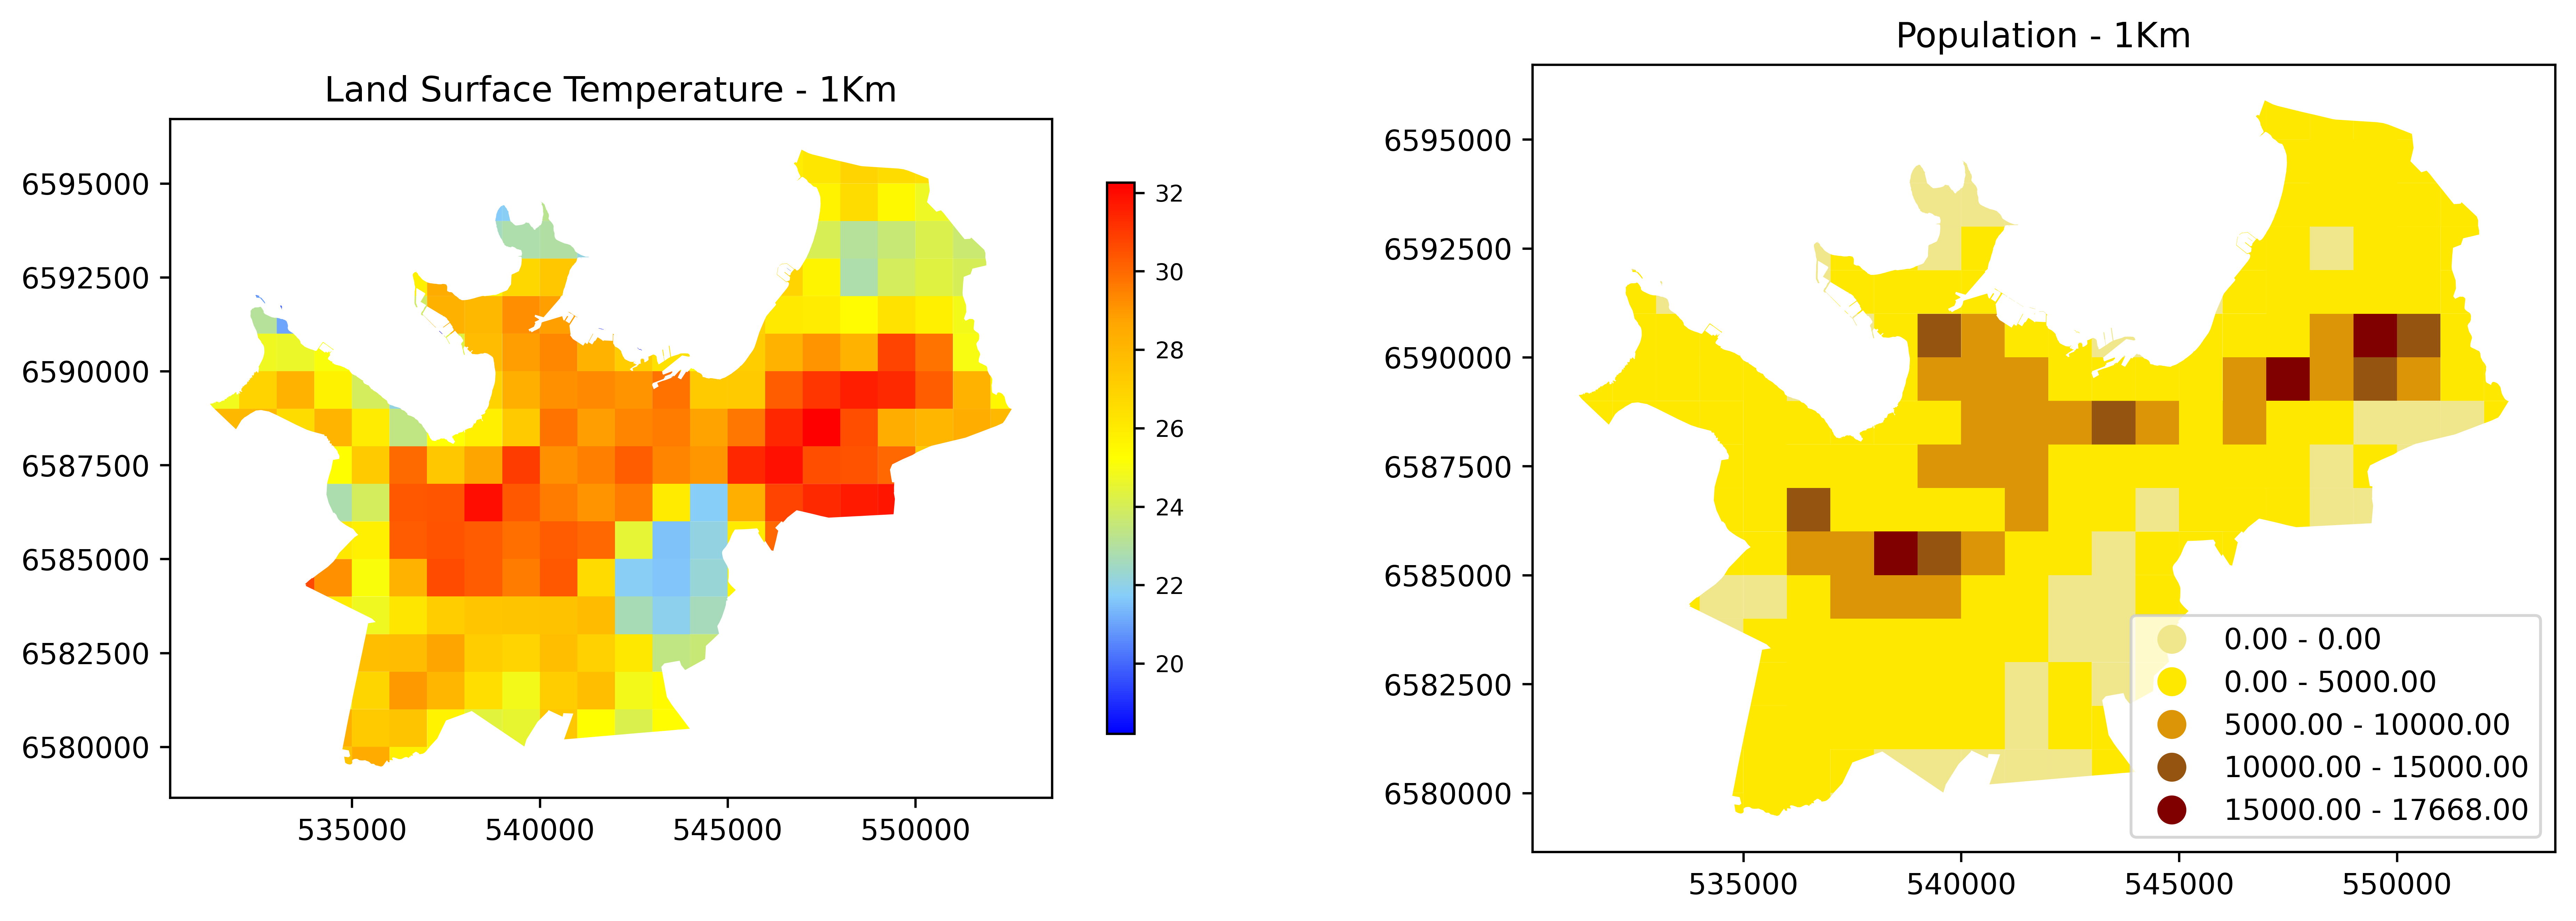

In [24]:
fig, axes = plt.subplots(1,2,figsize=(15,5),dpi=600) #create a figure with two subplots

ax1 , ax2 = axes.flatten() #flatten the axes to get individual matplotlib ax


#plot the LST in the first ax

ax1 = grids.plot(column='lst',     #define parameter of interest
                 cmap=lst_cmap,    
                 ax=ax1,           #set the ax 
                 legend=True,
                 legend_kwds={'shrink': 0.7})

#some extra tweaks to enhance the presentation

ax1.ticklabel_format(style='plain')
ax1.figure.axes[-1].tick_params(labelsize=8)
ax1.set_title('Land Surface Temperature - 1Km')




#plot the population

ax2 = grids.plot(column='pop',
                 cmap=pop_cmap ,
                 ax=ax2,
                 scheme='user_defined', classification_kwds={'bins':np.arange(0,18000,5000).tolist()}, #create a user defined scheme
                 legend=True,
                 legend_kwds={'loc': 'lower right'},
                )

ax2.ticklabel_format(style='plain')
ax2.figure.axes[-1].tick_params(labelsize=8)
ax2.set_title('Population - 1Km')


Planners, policy makers and public health users are mostly interested in exposure and vulnerability maps.

With the population information and the LST, we can create a single map the combines both parameters that will give 

interested persons an idea of the hottest zones within the area and 'the number of people exposed.

we will use splot value-by-alpha from pysal for this.

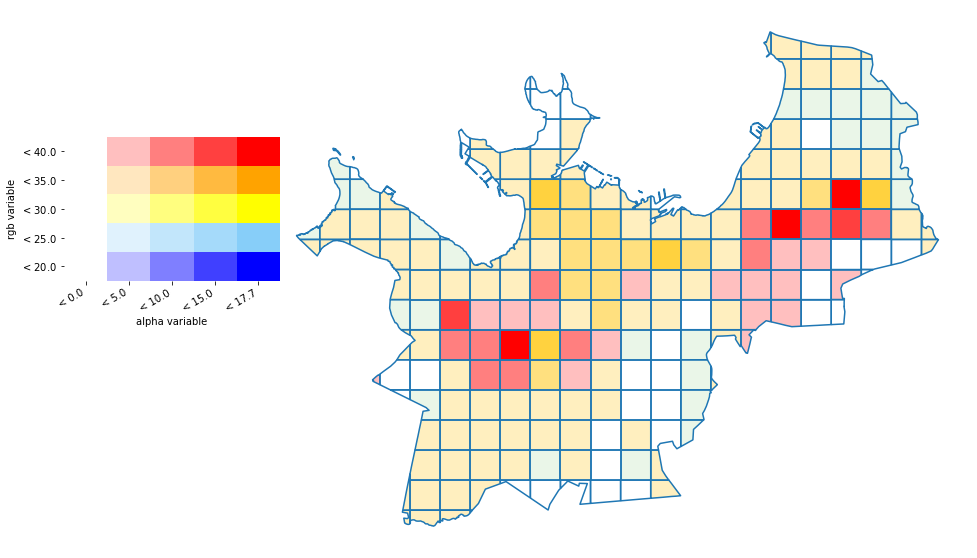

In [25]:
#Default plotting with pysal splot


x = grids['lst'].values
y = grids['pop'].values


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

grids.boundary.plot(ax=ax)
ax=vba_choropleth(x, y, grids, rgb_mapclassify=dict(classifier='user_defined',bins=[20,25,30,35,40]), cmap=lst_cmap,
                   alpha_mapclassify=dict(classifier='user_defined',bins=np.arange(0,18000,5000).tolist()),ax=ax,legend=True)



[Text(0, 0, '0'),
 Text(0, 0, '0-5000'),
 Text(0, 0, '5000-10000'),
 Text(0, 0, '10000-15000'),
 Text(0, 0, '15000-18000')]

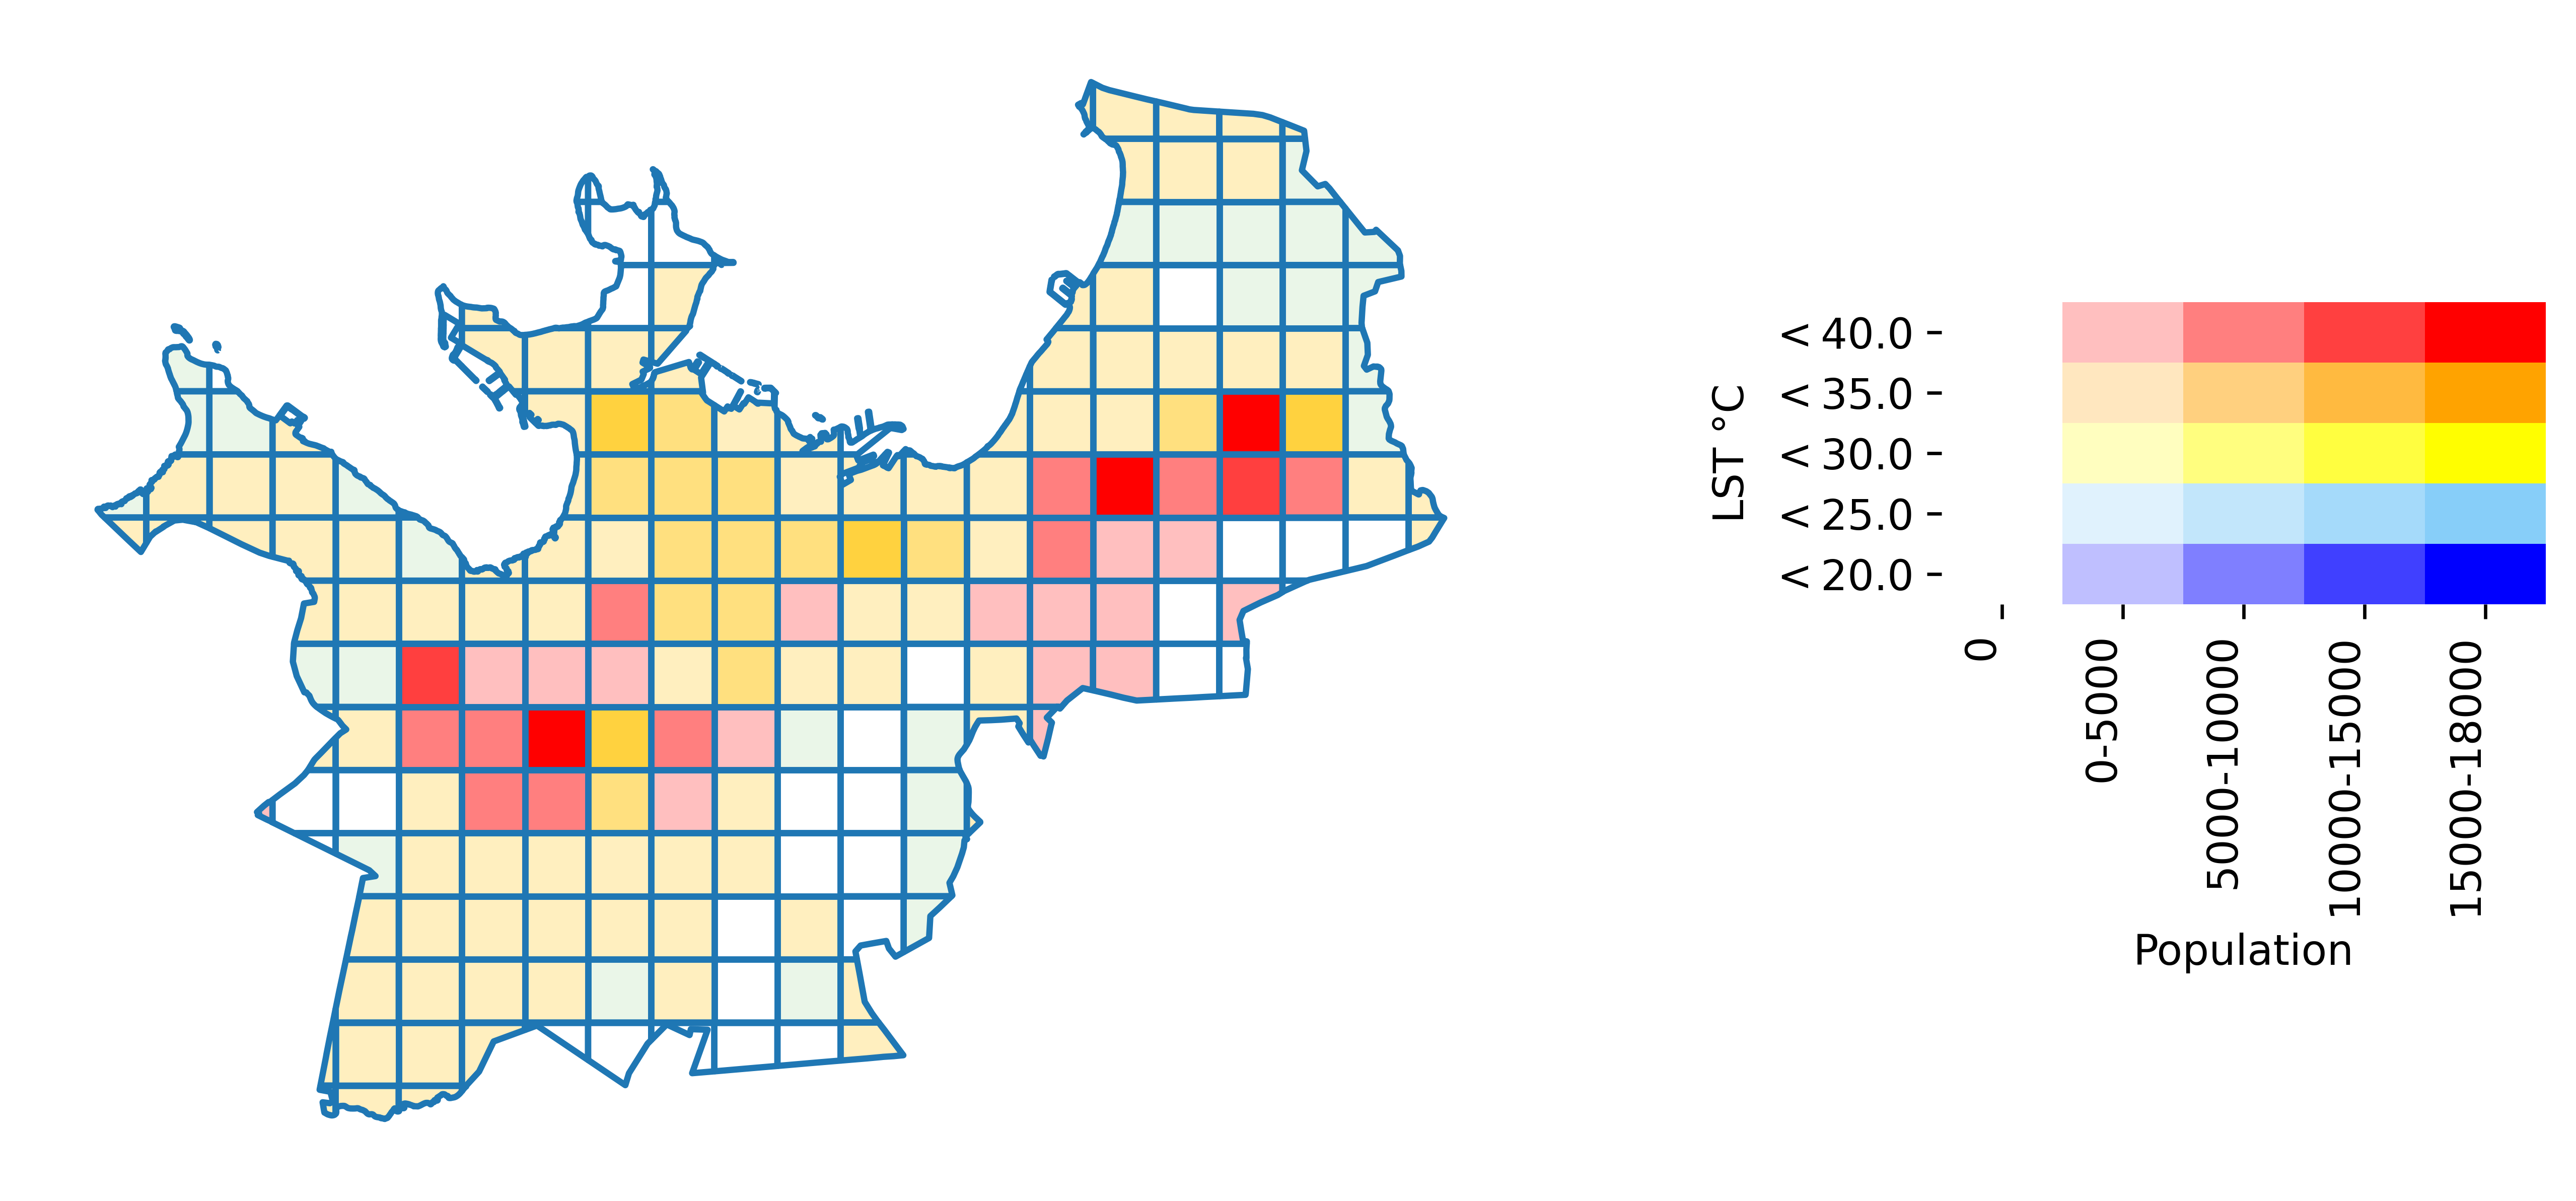

In [26]:
#custom plot with 



fig = plt.figure(dpi=600,figsize=(10,5))

ax1 = fig.add_subplot(111)

x = grids['lst'].values
y = grids['pop'].values

lst_bins = dict(classifier='user_defined',bins=[20,25,30,35,40]) #bins for the lst

pop_bins = dict(classifier='user_defined',bins=np.arange(0,18000,5000).tolist()) #bins for population
                
#plot grids and bivariate map for population and LST

grids.boundary.plot(ax=ax1)

ax1 = vba_choropleth(x, y, grids, rgb_mapclassify=lst_bins, cmap=lst_cmap,alpha_mapclassify=pop_bins,ax=ax1)




#create custom legend

rgb_bins = mapclassify_bin(x, classifier='user_defined',bins=[20,25,30,35,40]) 
alpha_bins = mapclassify_bin(y,classifier='user_defined',bins=np.arange(0,18000,5000).tolist()) #get bins for colours

left, bottom, width, height = [0.9, 0.5, 0.2, 0.2] #set position for legend within the figure 

ax2 = fig.add_axes([left, bottom, width, height]) #create axes for legend at desired position


vba_legend(rgb_bins, alpha_bins, cmap= lst_cmap, ax=ax2) #create legend

#set legend objects
ax2.set_xlabel('Population')
ax2.set_ylabel('LST °C')
ax2.set_xticklabels(['0','0-5000','5000-10000','10000-15000','15000-18000'],
                       rotation=90, horizontalalignment='right')

Finally we will make a geocube (data cube) from the grids dataframe and export

In [27]:

cube = make_geocube(vector_data=grids, resolution=(1000, 1000))
    
    
#cube.rio.to_raster('test1.tif')